# NYC Metro Challenge

## Field Description

- C/A = Control Area (A002)
- UNIT = Remote Unit for a station (R051)
- SCP = Subunit Channel Position represents an specific address for a device (02-00-00)
- DATEn = Represents the date (MM-DD-YY)
- TIMEn = Represents the time (hh:mm:ss) for a scheduled audit event
- DEScn = Represent the "REGULAR" scheduled audit event (occurs every 4 hours)
- ENTRIESn = The cumulative entry register value for a device
- EXISTn = The cumulative exit register value for a device

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

import glob
import shutil
import py7zr

## Understanding the Dataset

Let's begin importing just one dataset and work to understand the data

In [2]:
file_name = glob.glob('data/*.7z')
temp_folder = 'data/temp'

with py7zr.SevenZipFile(file_name[0], 'r') as archive:
    file_names = archive.getnames()
    archive.extractall(path=temp_folder)

    path_data_sets = glob.glob(temp_folder + '/*/*')
    df = pd.read_csv(path_data_sets[0])

try:
    shutil.rmtree(temp_folder)
except OSError as e:
   print("Error: %s - %s." % (e.filename, e.strerror))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7420384 entries, 0 to 7420383
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   time      object 
 1   ca        object 
 2   unit      object 
 3   scp       object 
 4   station   object 
 5   linename  object 
 6   division  object 
 7   desc      object 
 8   entries   float64
 9   exits     float64
dtypes: float64(2), object(8)
memory usage: 566.1+ MB


In [4]:
df.head(1)

,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2010-04-17 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2704717.0,928793.0


The columns are different from the field description. Since the original page of the data is not available, I'll have to guess here and a **research on the internet for a compleat documentation**.

**Field Description**

- TIME [TIME]:
    - Represents the time of the reported data (HH:MM:SS);
    - The normal interval between audit reports for the same device is 4 hours. The four hour intervals will differ from other stations due to the need for staggering to prevent flooding the system with audit readings all at once. Systemwide, stations have been set to begin audit transmittal between 00 to 03 hours, then every 4 hours after the first audit of the day;
    - Example: **02:00:00**.
- C/A [TEXT]:
    - Control Area name/Booth name. This is the internal identification of a booth at a given station;
    - Examples - **A002** (4 to 5 characters).
- UNIT [TEXT]:
    - Remote unit ID of station;
    - Examples - **R001** (4 characters. A numeric designation preceded by 'R').
- SCP [TEXT]:
    - Subunit/Channel/position represents a specific address for a given device;
    - Example: **01-00-01** - Normally six characters in groups of 2 separated by a dash.
- STATION [TEXT]:
    - Name assigned to the subway station by operations planning. This name is used in all references to stations, as well as in debit/credit purchase receipts, and customer’s bank activity statements;
    - Example: **34 ST-HERALD SQ** - Maximum station name length is 15 characters.
- LINENAME [TEXT]:
    - Train lines stopping at this location. Can contain up to 20 single character identifier. When more than one train line appears, it is usually intercepting train lines, in major stations where the passenger can transfer between any one of the lines;
    - Example: **456** - Maximum station name length is 15 characters.
- DIVISION [TEXT]:
    - Represents the Line originally the station belonged to BMT, IRT, or IND;
    - Each section of the system is assigned a unique line name, usually paired with its original operating company or division (Brooklyn–Manhattan Transit Corporation (BMT), Interborough Rapid Transit Company (IRT), and Independent Subway System (IND);
    - From a reseach on the internet I've found
        - 'IRT': 'Interborough Rapid Transit',
        - 'BMT': 'Brooklyn-Manhattan Transit',  
        - 'IND': 'Independent Subway',
        - 'PTH': 'Port Authority Trans-Hudson (PATH)',
        - 'RIT': 'Roosevelt Island Tram',
        - 'SRT': 'Staten Island Rapid Transit' 
    - Example: **BMT** - 3 character in length.
- DESC [TEXT]:
    - Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours):
        1. Audits may occur more frequently than 4 hours due to planning, or troubleshooting activities;
        2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. If a recovered audit is sent and is identical to the previous register reading, it will be omitted.
    - Example: **REGULAR**.
- ENTRIES [NUMERIC]:
    - The cumulative ENTRY register value for a device. This register was initialized during system setup. It is a 10 digit number representing the number of entries on the specific device since its inception. Other forms of initialization may occur upon roll-over of the counter, erasing the memory device containing the register data, and replacing the processing device of the turnstile;
    - Example: **0001649720**.
- EXITS [NUMERIC]:
    - The cumulative EXITS register value for a device. This register was initialized during system setup. It is a 10 digit number representing the number of entries on the specific device since its inception. Other forms of initialization may occur upon roll-over of the counter, erasing the memory device containing the register data, and replacing the processing device of the turnstile;
    - Example: **0004863606**.

Along with this field description I've found more documentation with important infos.

**Data Collection Methodology**

The audit register data is extracted from a central database weekly on Saturdays for posting. The actual register data is generated at the turnstile device every 4 hours at which time the device uploads the data to a central database.

**Statistical and Analytic Issues**

The data is broken down to Daily and Hourly periods. The data is 10 digits long and will roll-over to zero (0) on over-flow. Other factors that may impact the data are:
- Hardware failure where the hard drive needs to be replaced, and initialized;
- Data corruption from faulty devices, or heavy banging on the turnstile.

From that information I made some decisions about the use of this dataframe:
1. Use only the regular data defined by the field `desc == 'REGULAR`;
2. The `time` column must be transformed to the `pd.DateTime` type;
3. The accumulated counter can be reset due to unforeseen circumstances, so when calculating the instantaneous value, this care must be taken;
4. The datasets are huge, so the object columns with string values should be transformed to category type if the uniques values from each column are few in comparison to the total number of entries;
5. Sort the characters of `linename` column entries.

First transform the time columns from object to timestamp.

In [5]:
df['time'] = pd.to_datetime(df['time'])

Taking only the `desc == 'REGULAR'` entries.

In [6]:
df = df[df['desc'] == 'REGULAR']
df = df.drop(['desc'], axis = 1)

Count how many unique values are on each object column.

In [7]:
for column in df.columns:
        if df[column].dtypes == np.object0:
            print(f'{column.ljust(12)} {df[column].nunique()}')


ca           727
unit         467
scp          205
station      382
linename     107
division     6


The number of unique values is very small compared to the entire data frame. Let's convert these columns to categorical type.

In [8]:
object_columns = [_ for _ in df.columns if df[_].dtype == np.object0]
for column in object_columns:
        df[column] = pd.Categorical(df[column])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6099893 entries, 0 to 7420383
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   time      datetime64[ns]
 1   ca        category      
 2   unit      category      
 3   scp       category      
 4   station   category      
 5   linename  category      
 6   division  category      
 7   entries   float64       
 8   exits     float64       
dtypes: category(6), datetime64[ns](1), float64(2)
memory usage: 244.4 MB


The entries and exits are a discrete count so let's convert to integer type.

In [10]:
df['entries'] = df['entries'].astype('int')
df['exits'] = df['exits'].astype('int')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6099893 entries, 0 to 7420383
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   time      datetime64[ns]
 1   ca        category      
 2   unit      category      
 3   scp       category      
 4   station   category      
 5   linename  category      
 6   division  category      
 7   entries   int32         
 8   exits     int32         
dtypes: category(6), datetime64[ns](1), int32(2)
memory usage: 197.9 MB


The memory occupied by this dataframe is reasonably small, so let's work with it in its entirety without having to sample it.

In [12]:
df.head()

,time,ca,unit,scp,station,linename,division,entries,exits
0,2010-04-17 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,2704717,928793
1,2010-04-17 04:00:00,A002,R051,02-00-01,LEXINGTON AVE,456NQR,BMT,2697632,566683
2,2010-04-17 04:00:00,A002,R051,02-03-00,LEXINGTON AVE,456NQR,BMT,1127722,3943492
3,2010-04-17 04:00:00,A002,R051,02-03-01,LEXINGTON AVE,456NQR,BMT,2425570,3733289
4,2010-04-17 04:00:00,A002,R051,02-03-02,LEXINGTON AVE,456NQR,BMT,2214633,3021589


Let's take a closer look to the `linename` column where the description says:
- LINENAME [TEXT]:
    - Train lines stopping at this location. Can contain up to 20 single character identifier. When more than one train line appears, it is usually intercepting train lines, in major stations where the passenger can transfer between any one of the lines;
    - Example: **456** - Maximum station name length is 15 characters.

In [13]:
df['linename'].unique()

['456NQR', 'NQR', '1237ACENQRS', 'BDFMNQR', 'NR', ..., 'BDFQ6', '2345ACJZ', '2', 'EM', '123ACE']
Length: 108
Categories (107, object): ['1', '123', '1237ACENQRS', '123ACE', ..., 'R1', 'R2345', 'S', 'S2345']

We have two different values for apparently the same `linename` due to character sorting problems.:
- LNQR456;
- LNRQ456.

So we need to sort this characters in all strings of this column.

In [14]:
def sort_linename(linename):
    """
    Receive a string and sort its characters.

    Args:
        linename (string): Lines that cross a given station.

    Returns:
        string: Sorted train lines.
    """
    linename = str(linename)
    return ''.join(sorted(linename))

In [15]:
df.linename = pd.Categorical(df.linename.apply(sort_linename))

In [16]:
df['linename'].nunique()

92

The older number of unique values in this columns was 107 and now is 93. Now let's sort the columns.

In [17]:
df = df[['time', 'division', 'station', 'unit', 'linename','ca', 'scp', 'entries', 'exits']]
df.head()

,time,division,station,unit,linename,ca,scp,entries,exits
0,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2704717,928793
1,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-01,2697632,566683
2,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-00,1127722,3943492
3,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-01,2425570,3733289
4,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-02,2214633,3021589


Now we check if this cumulative entries and exits count grow in a regular speed.
1. We first choose a value for each column to find the counts for a single turnstile.

In [18]:
sample_division = 'BMT'
sample_station = 'LEXINGTON AVE'
sample_unit = 'R051'
sample_linename = '456NQR'
sample_ca = 'A002'
sample_scp = '02-00-00'

mask_turnstile = (df.division == sample_division) \
    & (df.station == sample_station) \
    & (df.unit == sample_unit) \
    & (df.linename == sample_linename) \
    & (df.ca == sample_ca) \
    & (df.scp == sample_scp)

2. Use this mask to filter just one turnstile.

In [19]:
df_sample = df[mask_turnstile]
df_sample.head()

,time,division,station,unit,linename,ca,scp,entries,exits
0,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2704717,928793
4795,2010-04-17 08:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2704723,928795
10865,2010-04-17 12:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2704731,928816
15916,2010-04-17 16:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2704835,928898
20902,2010-04-17 20:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2705074,928943


3. Plot the cumulative count for the entries and exits values from this turnstile to inquire the count.

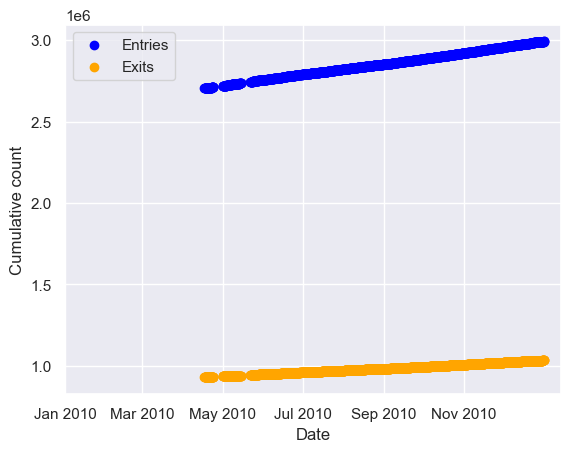

In [20]:
months_interval = [datetime(2010, month, 1) for month in range(1, 13, 2)]
plt.rc('date.autoformatter', day='%b %Y')

plt.scatter(x=df_sample.time, y=df_sample.entries, color='blue', label='Entries')
plt.scatter(x=df_sample.time, y=df_sample.exits, color='orange', label='Exits')
plt.ylabel('Cumulative count')
plt.xlabel('Date')
plt.xticks(months_interval)
plt.legend()
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
plt.show()

Cumulative entries and exits counts grow at constant rates. Now we need a method that samples this dataframe at different frequencies.

4. Sample this DataFrame in a temporal serie with a monthly frequency.

In [21]:
group_sample = df_sample.groupby([pd.Grouper(key='time', freq='M')]).agg(
    entries=('entries', 'unique'),
    exits=('exits', 'unique')
).reset_index()

In [22]:
group_sample.head()

,time,entries,exits
0,2010-04-30,"[2704717, 2704723, 2704731, 2704835, 2705074, ...","[928793, 928795, 928816, 928898, 928943, 92898..."
1,2010-05-31,"[2721143, 2721154, 2721172, 2721259, 2721479, ...","[934743, 934746, 934771, 934853, 934928, 93498..."
2,2010-06-30,"[2756507, 2756565, 2756566, 2756612, 2756780, ...","[947574, 947593, 947596, 947692, 947994, 94805..."
3,2010-07-31,"[2791678, 2791833, 2791835, 2791859, 2792019, ...","[960153, 960171, 960176, 960237, 960463, 96053..."
4,2010-08-31,"[2822921, 2823005, 2823024, 2823028, 2823067, ...","[971379, 971391, 971397, 971406, 971439, 97147..."


On each entry on `entries` and `exits` column we have an array whit the cumulative count on that monthly frequency, so:

 5. Write the a method that takes a series with cumulated count and return the instant value.

In [23]:
def series_deacumulate(serie):
    """
        This method takes a series with cumulated count and return the instant value of each entry by de-acumulate the count.
        It also drops any negative value generated by the reset of the accumulated counter.

    Args:
        serie (np.array): Cumulative count sequence.
    """
    
    diff_serie = serie[1:] - serie[:-1]
    new_serie = diff_serie[diff_serie >= 0]
    return new_serie

In [24]:
group_sample['entries'] = group_sample['entries'].apply(series_deacumulate).apply(sum)
group_sample['exits'] = group_sample['exits'].apply(series_deacumulate).apply(sum)

In [25]:
group_sample.head()

,time,entries,exits
0,2010-04-30,8382,2980
1,2010-05-31,35162,12788
2,2010-06-30,34404,12509
3,2010-07-31,31025,11203
4,2010-08-31,29536,10756


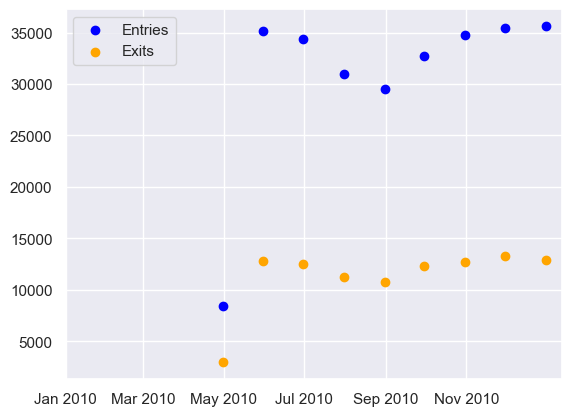

In [26]:
months_interval = [datetime(2010, month, 1) for month in range(1, 13, 2)]
plt.rc('date.autoformatter', day='%b %Y')

plt.scatter(x=group_sample.time, y=group_sample.entries, color='blue', label='Entries')
plt.scatter(x=group_sample.time, y=group_sample.exits, color='orange', label='Exits')
plt.legend()
plt.xticks(months_interval)
plt.show()

The graph with the number of passengers per month of a single turnstile shows a typical behavior of a time series, with moments of high and low movement.

These methods filters, samples the data according to a temporal frequency, groups and calculates the instantaneous value of entries and exits.

### Data Processing Methods

Here we will group the methods used to process the data for this analysis.

In [27]:
def sort_linename(linename):
    """
    Receive a string and sort its characters.

    Args:
        linename (string): Lines that cross a given station.

    Returns:
        string: Sorted train lines.
    """
    linename = str(linename)
    return ''.join(sorted(linename))

In [28]:

def read_mta_data(file_path):
    """
    Read a csv file from the NYC MTA:
    
        1. Filters the entries with desc == 'REGULAR';
        2. Converts the time columns to timestamp format;
        3. Sort the lines in the linename column;
        4. Converts the object columns to category type.

    Args:
        file_path (string): Path to the .csv file.

    Returns:
        pd.DataFrame: preprocessed MTA DataFrame.
    """
    
    df = pd.read_csv(file_path)
    
    df = df[df.desc == 'REGULAR']
    df = df.drop(['desc'], axis = 1)
    
    df.time = pd.to_datetime(df.time)
    df.linename= df.linename.apply(sort_linename)
    
    object_columns = [_ for _ in df.columns if df[_].dtype == np.object0]
    for column in object_columns:
        df[column] = pd.Categorical(df[column])
        
    df.entries = df.entries.astype('int32')
    df.exits = df.exits.astype('int32')
    
    df = df[['time', 'division', 'station', 'unit', 'linename','ca', 'scp', 'entries', 'exits']]
    
    return df

In [29]:
def series_deacumulate(serie):
    """
        This method takes a series with cumulated count and return the instant value of each entry by de-acumulate the count.
        It also drops any negative value generated by the reset of the accumulated counter.

    Args:
        serie (np.array): Cumulative count sequence.
    """
    
    diff_serie = serie[1:] - serie[:-1]
    new_serie = diff_serie[diff_serie >= 0]
    return new_serie

In [30]:
def group_data(df, freq, division, station, unit, linename, ca, scp):
    
    """
    
    Receives a DataFrame with the data sampling frequency and the turnstile filtering parameters.
    
    The cumulative entries and exits are grouped along a timestamp with the defined frequency.
    
    A new DataFrame is build with the parameters columns and the instant value for entries and exits.

    Returns:
        pd.DataFrame: Instant entries and exits DataFrame with new frequency time column.
    """
    
    df = df[
        (df.division == division) \
        & (df.station == station) \
        & (df.unit == unit) \
        & (df.linename == linename) \
        & (df.ca == ca) \
        & (df.scp == scp) \
    ]
    
    group = df.groupby(
        [
            pd.Grouper(key='time', freq=freq)
        ]
    ).agg(
        entries=('entries', 'unique'),
        exits=('exits', 'unique')
    ).reset_index()
    
    df_time_series = pd.DataFrame({}, columns=['time'])
    
    df_time_series.time = group.time
    df_time_series['divison'] = division
    df_time_series['station'] = station
    df_time_series['unit'] = unit
    df_time_series['linename'] = linename
    df_time_series['ca'] = ca
    df_time_series['scp'] = scp
    df_time_series['entries_inst'] = group['entries'].apply(series_deacumulate).apply(sum).astype('int32')
    df_time_series['exits_inst'] = group['exits'].apply(series_deacumulate).apply(sum).astype('int32')
    
    return df_time_series

## Importing Datasets

Unpacking the 7zip file and importing the data.

In [31]:
file_name = 'data/Dataset-Prova.7z'
temp_folder = 'data/temp'

with py7zr.SevenZipFile(file_name, 'r') as archive:
    archive.extractall(path=temp_folder)
    
    path_data_sets = glob.glob(temp_folder + '/*/*')
    df_concat = pd.concat([read_mta_data(_) for _ in path_data_sets], ignore_index=True)
    
try:
    shutil.rmtree(temp_folder)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

In [32]:
df_concat.head()

,time,division,station,unit,linename,ca,scp,entries,exits
0,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2704717,928793
1,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-01,2697632,566683
2,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-00,1127722,3943492
3,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-01,2425570,3733289
4,2010-04-17 04:00:00,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-02,2214633,3021589


In [33]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72112005 entries, 0 to 72112004
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   time      datetime64[ns]
 1   division  category      
 2   station   object        
 3   unit      object        
 4   linename  object        
 5   ca        object        
 6   scp       object        
 7   entries   int32         
 8   exits     int32         
dtypes: category(1), datetime64[ns](1), int32(2), object(5)
memory usage: 3.8+ GB


Exporting data to file in order to save time.

In [34]:
df_concat.to_parquet('data/df_preprocessed.gzip', compression='gzip')

## Exploratory data analysis

Let's check an annual serie for one turnstile.

In [35]:
df = pd.read_parquet('data/df_preprocessed.gzip')

In [36]:
datetime_start = datetime(2010, 12, 1)
datetime_end = datetime(2010, 12, 31)

df_12 = df[(df.time >= datetime_start) & (df.time <= datetime_end)]

In [37]:
df_12.head()

,time,division,station,unit,linename,ca,scp,entries,exits
5319861,2010-12-01,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-00,2957965,1020696
5319862,2010-12-01,BMT,LEXINGTON AVE,R051,456NQR,A002,02-00-01,2925108,620088
5319863,2010-12-01,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-00,1219314,4325752
5319864,2010-12-01,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-01,2671400,4123750
5319865,2010-12-01,BMT,LEXINGTON AVE,R051,456NQR,A002,02-03-02,2451415,3358224


In [38]:
df_12.tail()

,time,division,station,unit,linename,ca,scp,entries,exits
6077334,2010-12-31,SRT,ST. GEORGE,R070,1,S101A,01-06-03,1640872,8424
6077335,2010-12-31,SRT,ST. GEORGE,R070,1,S101A,01-07-00,229149,75
6077336,2010-12-31,SRT,ST. GEORGE,R070,1,S101A,01-07-01,1052510,294
6077337,2010-12-31,SRT,ST. GEORGE,R070,1,S101A,01-07-02,2109049,19964
6077338,2010-12-31,SRT,ST. GEORGE,R070,1,S101A,01-07-03,2225514,23377


In [39]:
group_12 = df.groupby(
        [
            pd.Grouper(key='time', freq='d')
        ]
    ).agg(
        entries=('entries', 'sum'),
        exits=('exits', 'sum')
    ).reset_index()
group_12

,time,entries,exits
0,2010-04-17,58125484211,48377166415
1,2010-04-18,70771741591,59414907859
2,2010-04-19,73825114476,62050327033
3,2010-04-20,72349860551,59996667118
4,2010-04-21,70543813803,59832485969
...,...,...,...
2712,2017-09-19,1117203099412,892667996628
2713,2017-09-20,1134719631864,906621018960
2714,2017-09-21,1144419484956,920175240094
2715,2017-09-22,1120715200606,893089093243


# Testing plots

In [ ]:
df_concat[(df_concat.division == 'BMT')].station.unique()

['1 AV',
 '1 AVE',
 '104 ST',
 '111 ST',
 '121 ST',
 '14 ST-UNION SQ',
 '18 AV',
 '18 AVE',
 '20 AV',
 '20 AVE',
 '23 ST',
 '23 ST-5 AVE',
 '25 AV',
 '25 AVE',
 '25 ST',
 '28 ST',
 '28 ST-BROADWAY',
 '3 AV',
 '3 AVE',
 '30 AV',
 '34 ST-HERALD SQ',
 '36 AV',
 '36 ST',
 '39 AV',
 '42 ST-TIMES SQ',
 '45 ST',
 '49 ST',
 '49 ST-7 AVE',
 '4AV-9 ST',
 '5 AV/59 ST',
 '5 AVE-59 ST',
 '50 ST',
 '53 ST',
 '55 ST',
 '57 ST-7 AV',
 '57 ST-7 AVE',
 '59 ST',
 '6 AV',
 '6 AVE',
 '7 AV',
 '7 AVE',
 '71 ST',
 '75 ST-ELDERTS',
 '77 ST',
 '79 ST',
 '8 AV',
 '8 AVE',
 "8 ST-B'WAY NYU",
 '8 ST-NYU',
 '85 ST-FOREST PK',
 '86 ST',
 '9 AV',
 '9 AVE',
 '9 ST',
 'ALABAMA AV',
 'ALABAMA AVE',
 'ASTORIA BLVD',
 'ASTORIA DITMARS',
 'ATL AV-BARCLAY',
 'ATLANTIC AV',
 'ATLANTIC AVE',
 'AVE H',
 'AVE J',
 'AVE M',
 'AVE U',
 'AVENUE H',
 'AVENUE J',
 'AVENUE M',
 'AVENUE U',
 'BARCLAYS CENTER',
 'BAY 50 ST',
 'BAY PARKWAY',
 'BAY PKWY',
 'BAY PKY-22 AVE',
 'BAY RIDGE AV',
 'BAY RIDGE AVE',
 'BAY RIDGE-95 ST',
 'BEDFOR

In [ ]:
df_concat[(df_concat.division == 'BMT') & (df_concat.station == '28 ST-BROADWAY')].head()

,time,division,station,unit,linename,ca,scp,entries,exits
70,2010-04-17 04:00:00,BMT,28 ST-BROADWAY,R082,NR,A027,01-00-00,3153294,3396650
71,2010-04-17 04:00:00,BMT,28 ST-BROADWAY,R082,NR,A027,01-03-00,842296,419398
72,2010-04-17 04:00:00,BMT,28 ST-BROADWAY,R082,NR,A027,01-03-01,3080832,1648976
73,2010-04-17 04:00:00,BMT,28 ST-BROADWAY,R082,NR,A027,01-03-02,66779,66297
74,2010-04-17 04:00:00,BMT,28 ST-BROADWAY,R082,NR,A027,01-03-03,49812,92328


In [ ]:
group = group_data(df_concat, 'Y', 'BMT', '28 ST-BROADWAY', 'R082', 'NR', 'A027', '01-00-00')

#months_interval = [datetime(2010, month, 1) for month in range(1, 13, 2)]
#plt.rc('date.autoformatter', day='%b %Y')

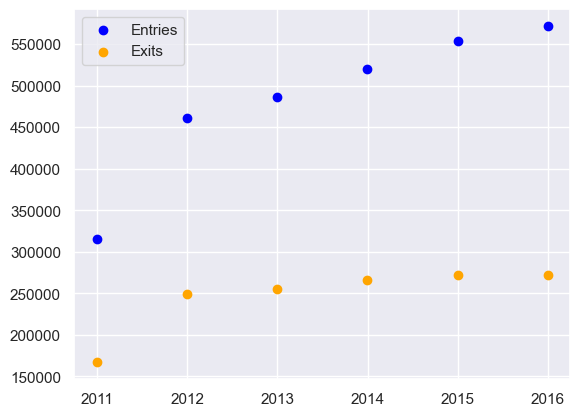

In [62]:
plt.scatter(x=group.time, y=group.entries_inst, color='blue', label='Entries')
plt.scatter(x=group.time, y=group.exits_inst, color='orange', label='Exits')
plt.legend()
#plt.xticks(months_interval)
plt.show()

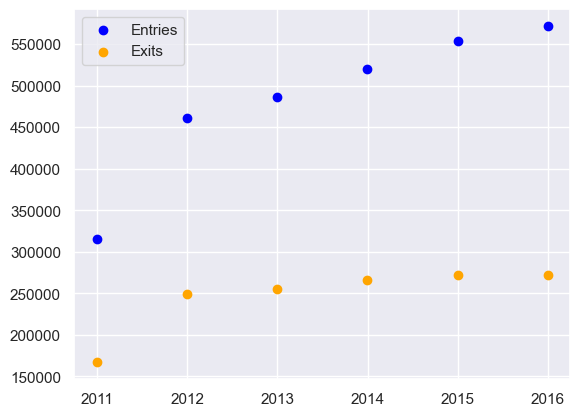

In [53]:
group = group_data(df_concat, 'Y', 'BMT', '28 ST-BROADWAY', 'R082', 'NR', 'A027', '01-03-00')

#months_interval = [datetime(2010, month, 1) for month in range(1, 13, 2)]
#plt.rc('date.autoformatter', day='%b %Y')

plt.scatter(x=group.time, y=group.entries_inst, color='blue', label='Entries')
plt.scatter(x=group.time, y=group.exits_inst, color='orange', label='Exits')
plt.legend()
#plt.xticks(months_interval)
plt.show()

In [ ]:
df_concat[(df_concat.division == 'IND')].station.unique()

array(['190 ST', '175 ST', '168 ST-BROADWAY', '145 ST', '125 ST', '96 ST',
       '86 ST', '72 ST', '59 ST-COLUMBUS', '50 ST', '42 ST-PA BUS TE',
       '34 ST-PENN STA', '23 ST', 'SPRING ST', 'CANAL ST', 'CHAMBERS ST',
       'WORLD TRADE CTR', 'HIGH ST', 'JAY ST-METROTEC', 'HOYT/SCHERMER',
       'CLINTON-WASH AV', 'NOSTRAND AVE', 'KINGSTON-THROOP',
       'BROADWAY-ENY', 'EUCLID AVE', 'GRANT AVE', 'OXFORD-104 ST',
       'LEFFERTS BLVD', 'AQUEDUCT TRACK', 'BEACH 67 ST', 'BEACH 60 ST',
       'BEACH 44 ST', 'BEACH 36 ST', 'BEACH 25 ST', 'FAR ROCKAWAY',
       '167 ST', '174-175 ST', '182-183 ST', 'FORDHAM ROAD',
       'LEXINGTON-53 ST', 'STEINWAY ST', 'ROOSEVELT AVE', 'ELMHURST AVE',
       'GRAND AV-NEWTON', '63 DR-REGO PARK', '67 AVE', '75 AVE',
       'VAN WYCK BLVD', 'PARSONS BLVD', '169 ST', 'JAMAICA-179 ST',
       'GREENPOINT AVE', 'NASSAU AV', 'BEDFORD/NOSTRAN', 'CLASSON AVE',
       'FULTON ST', '47-50 ST-ROCK', '42 ST-BRYANT PK', '34 ST-HERALD SQ',
       '23 ST-6 AVE', '1

In [ ]:
df_concat[(df_concat.division == 'IND') & (df_concat.station == 'JFK HOWARD BCH')].head()

,time,division,station,unit,linename,ca,scp,entries,exits
2719,2010-04-17 05:00:00,IND,JFK HOWARD BCH,R535,A,JFK01,00-00-01,92999,18335
2720,2010-04-17 05:00:00,IND,JFK HOWARD BCH,R535,A,JFK01,00-00-02,4690,26593
2721,2010-04-17 05:00:00,IND,JFK HOWARD BCH,R535,A,JFK01,00-00-03,160582,31610
2722,2010-04-17 05:00:00,IND,JFK HOWARD BCH,R535,A,JFK02,01-00-01,19242,7097
2723,2010-04-17 05:00:00,IND,JFK HOWARD BCH,R535,A,JFK02,01-00-02,1090060,606500


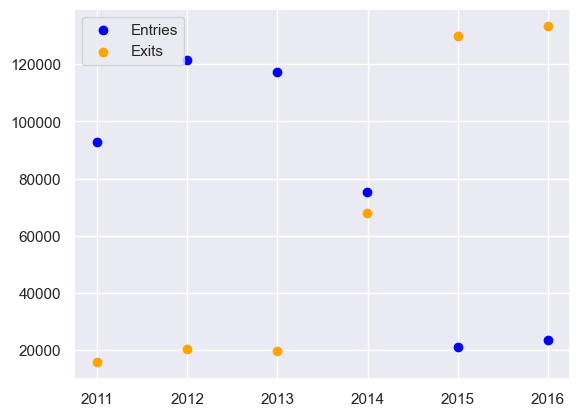

In [ ]:
group = group_data(df_concat, 'Y', 'IND', 'JFK HOWARD BCH', 'R535', 'A', 'JFK01', '00-00-01')

#months_interval = [datetime(2010, month, 1) for month in range(1, 13, 2)]
#plt.rc('date.autoformatter', day='%b %Y')

plt.scatter(x=group.time, y=group.entries_inst, color='blue', label='Entries')
plt.scatter(x=group.time, y=group.exits_inst, color='orange', label='Exits')
plt.legend()
#plt.xticks(months_interval)
plt.show()

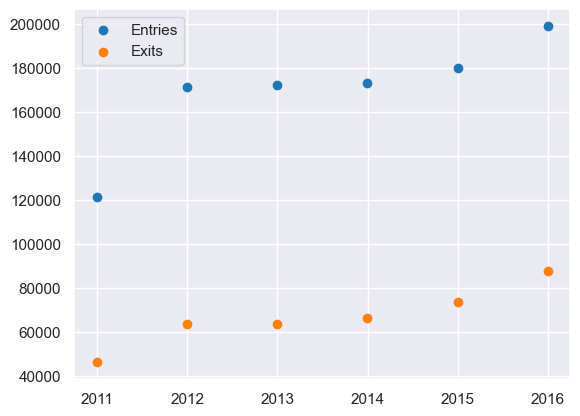

In [ ]:
group = group_data(df_concat, 'Y', 'IND', 'JFK HOWARD BCH', 'R535', 'A', 'JFK02', '01-00-02')

#months_interval = [datetime(2010, month, 1) for month in range(1, 13, 2)]
#plt.rc('date.autoformatter', day='%b %Y')

plt.scatter(x=group.time, y=group.entries_inst, color='tab:blue', label='Entries')
plt.scatter(x=group.time, y=group.exits_inst, color='tab:orange', label='Exits')
plt.legend()
#plt.xticks(months_interval)
plt.show()

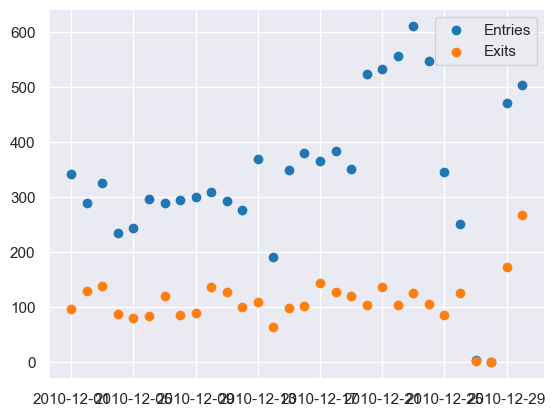

In [ ]:
group = group_data(df_12, 'd', 'IND', 'JFK HOWARD BCH', 'R535', 'A', 'JFK02', '01-00-02')

plt.scatter(x=group.time, y=group.entries_inst, color='tab:blue', label='Entries')
plt.scatter(x=group.time, y=group.exits_inst, color='tab:orange', label='Exits')
plt.legend()
#plt.xticks(months_interval)
plt.show()